# Problem example

Model economic characteristics of urban neighborhoods (zip code areas), such as  
**income, unemployment or average real estate prices using the structure of 311 complains**  
as a signature of social activity.

[Wang L, Qian C, Kats P, Kontokosta C, Sobolevsky, S. (2017) Structure of 311
service requests as a signature of urban location. PloS ONE. 12(10), e0186314.]

<img src="data/fig5.png">

<img src="data/fig2.png">

We see that complaining patterns cluster in space but are pretty different for different urban neighborhoods. While the clusters with distinctive complaining profiles are also distinctive in terms of demography and economic background.

**What is we use the relative frequency of each of the 162 categories of complains as features to model target economic indicators accross NYC zip code areas?**

What issues such a model might face?

#### 311 service requests data.
https://en.wikipedia.org/wiki/3-1-1

3-1-1 is a special telephone number supported in many communities in Canada and the United States. The number provides access to non-emergency municipal services. The number format follows the N11 code for a group of short, special-purpose local numbers as designated in the North American Numbering Plan.
The number 3-1-1 is intended in part to divert routine inquiries and non-urgent community concerns from the 9-1-1 number which is reserved for emergency service. A promotional website for 3-1-1 in Akron described the distinction as follows: "Burning building? Call 9-1-1. Burning Question? Call 3-1-1."

In [4]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing

### Load 311 data

In [6]:
data311 = pd.read_csv( 'HW3_ADS/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [7]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [8]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [9]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [10]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [11]:
list_311=list(data311.columns)

In [12]:
list_311[0:10]

['APPLIANCE',
 'Adopt-A-Basket',
 'Air Quality',
 'Animal Abuse',
 'Animal Facility - No Permit',
 'Animal in a Park',
 'Asbestos',
 'BEST/Site Safety',
 'Beach/Pool/Sauna Complaint',
 'Bike Rack Condition']

In [13]:
len(data311)

264

In [14]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [15]:
len(data311) #only 179 zip codes with reliable data left

179

### Apply PCA to 311 data

In [16]:
scaler311 = preprocessing.StandardScaler().fit(data311)
data311S=scaler311.transform(data311)  

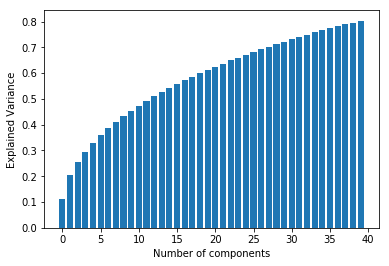

In [17]:
#perform PC decomposition over data311
pca = PCA(data311.shape[1])
data311P=pca.fit_transform(data311S)
eigenvalues = pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=40
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [26]:
# create borough labels 
Z=np.array(data311.index)
manhattanInd=(Z>10000)&(Z<10300)&(Z!=10026)&(Z!=10027)&(Z!=10029)&(Z!=10030)&(Z!=10037)&(Z!=10038) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
D=Z*0 
D[manhattanInd]=1
D[statenInd]=2
D[brooklynInd]=3
D[queensInd]=4
D[bronxInd]=5

179

In [25]:
data311P.shape

(179, 162)

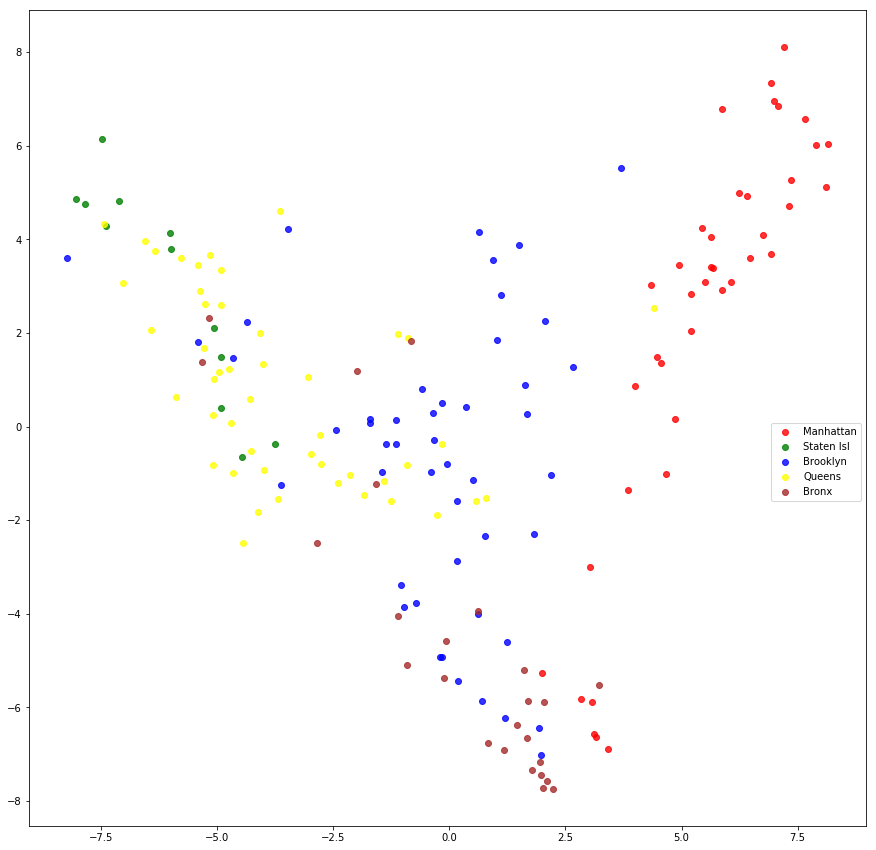

In [19]:
#2-d plot
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(15,15))
for d in range(1,6):
    plt.plot(np.array(data311P[D==d,0]), np.array(data311P[D==d,1]),
        'o', color=colors[d], alpha=0.8, label=d)
#plt.xlim((-0.2,0.2))   
#plt.ylim((-0.2,0.2)) 
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],bbox_to_anchor=(1, 0.5))

### Can 311 data over the zip codes can model median income?

In [16]:
dataIncome=pd.read_csv("data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [17]:
DataIncome1=dataIncome.merge(data311,left_index=True,right_index=True)

In [18]:
data311P=pd.DataFrame(data311P,index=data311.index)
DataIncome2=dataIncome.merge(data311P,left_index=True,right_index=True)

In [19]:
np.random.seed(2018)
splitind=np.random.uniform(size=len(DataIncome1))
DataIncome11=DataIncome1.loc[splitind<=0.5]
DataIncome12=DataIncome1.loc[(splitind>0.5)&(splitind<0.8)]
DataIncome13=DataIncome1.loc[splitind>=0.8]
DataIncome21=DataIncome2.loc[splitind<=0.5]
DataIncome22=DataIncome2.loc[(splitind>0.5)&(splitind<0.8)]
DataIncome23=DataIncome2.loc[splitind>=0.8]

In [20]:
np.random.seed(2018)
# Apply cross-validation to diagnose model for overfitting
R_IS=[]; R_OS=[] #lists for recording in-sample (training) and out-of-sample (test) R2
n=20 #number of runs
data=DataIncome1.iloc[:,3:]
Y=DataIncome1.Median
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(data,Y,test_size=0.5) #randomly split data into training (70%) and test (30%)
    res=LinearRegression(fit_intercept=True)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 20 times is 1.0
OS R-squared for 20 times is -2.06976151519


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [21]:
# Apply cross-validation to diagnose model for overfitting
R_IS=[]; R_OS=[] #lists for recording in-sample (training) and out-of-sample (test) R2
n=20 #number of runs
data=DataIncome2.iloc[:,3:13]
Y=DataIncome2.Median
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(data,Y,test_size=0.5) #randomly split data into training (70%) and test (30%)
    res=LinearRegression(fit_intercept=True)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 20 times is 0.766183966354
OS R-squared for 20 times is 0.438251553774


# Task 3. 
Repeat the analysis for median price per sq.foot from Zillow. See if 311 data could help

In [22]:
zillow=pd.read_csv("data/Zip_MedianListingPricePerSqft_AllHomes.csv",index_col=0)
zillow.head()

,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
RegionName,,,,,,,,,,,,,,,,,,,,,
10023,New York,NY,"New York, NY",New York,1,NaN,NaN,NaN,NaN,1366.621067,...,1954.992968,1983.055556,1963.986600,1702.573836,1522.948540,1568.100358,1612.378790,1569.371728,1599.538839,1619.794484
60614,Chicago,IL,"Chicago, IL",Cook,2,347.391304,333.975410,332.666667,324.490763,325.832510,...,514.255544,522.193211,519.321330,520.408163,476.592732,463.928571,470.769231,461.960986,455.861397,436.111111
79936,El Paso,TX,"El Paso, TX",El Paso,3,88.688320,88.159032,87.940589,87.929656,87.368706,...,88.419016,88.540363,88.755279,88.455330,88.367347,89.118199,90.128755,90.316333,90.726125,91.668726
10002,New York,NY,"New York, NY",New York,4,NaN,NaN,NaN,NaN,NaN,...,2041.247701,2043.165468,2063.785322,2012.302285,2015.369804,2026.353276,2022.274326,2013.831259,1997.942387,2030.259366
926,San Juan,TX,"Brownsville, TX",Cameron,5,NaN,NaN,NaN,NaN,NaN,...,92.968750,92.954963,93.776641,92.968750,95.090118,103.846154,100.411523,108.447489,102.270729,102.270729


# House price prediction using 311 data

### Can 311 complaining profile of urban neighborhoods enhance real-estate price prediction?

[Zhu, E., & Sobolevsky, S. (2018). House Price Modeling with Digital Census. arXiv preprint arXiv:1809.03834.]

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample (approximately 30% of the total) of more than 2000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [23]:
REsample=pd.read_csv('data/NYChome_sales2012.csv',index_col=0)

In [24]:
len(REsample)

14611

In [25]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [26]:
REsample.columns

Index([u'borough', u'neighborhood', u'block', u'lot', u'easement',
       u'building_class_present', u'address', u'zip_code',
       u'commmercial_units', u'land_sq_feet', u'gross_sq_feet', u'year_built',
       u'sale_price', u'sale_date'],
      dtype='object')

In [27]:
np.bincount(REsample.borough)

array([   0,  216,  894, 2769, 7288, 3444])

In [28]:
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample))
REsample1=REsample.loc[splitind<=0.2]
REsample2=REsample.loc[(splitind>0.2)&(splitind<0.6)]
REsample3=REsample.loc[(splitind>0.6)&(splitind<=1)]

In [29]:
len(REsample1) #loosing around 50 records within sparse zip codes

2953

In [30]:
len(REsample2)

5818

In [31]:
len(REsample3)

5840

### OLS 

In [32]:
# Run a linear regression (using statsmodels: "sale_price"~"gross_sq_feet"+"land_sq_feet"+"year_built"
base_columns=["gross_sq_feet","land_sq_feet","year_built"]
res=sm.OLS(REsample1.sale_price,sm.add_constant(REsample1.loc[:,base_columns]),missing="drop").fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 01 Oct 2018   Prob (F-statistic):           7.39e-97
Time:                        12:35:08   Log-Likelihood:                -44869.
No. Observations:                2953   AIC:                         8.975e+04
Df Residuals:                    2949   BIC:                         8.977e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          7.736e+06   1.29e+06      5.994

In [33]:
#If using statsmodels formula
lm = smf.ols(formula='sale_price ~ gross_sq_feet+land_sq_feet+year_built', data = REsample1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 01 Oct 2018   Prob (F-statistic):           7.39e-97
Time:                        12:35:08   Log-Likelihood:                -44869.
No. Observations:                2953   AIC:                         8.975e+04
Df Residuals:                    2949   BIC:                         8.977e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      7.736e+06   1.29e+06      5.994

In [34]:
#If using sklearn
lm=LinearRegression()
lm.fit(REsample1[["gross_sq_feet","land_sq_feet","year_built"]],REsample1.sale_price)
lm.coef_

array([  423.76983352,   -35.32608953, -4116.72594753])

# Now add all 311 to the house price regression

In [35]:
#add 311 data
REsample1=REsample1.merge(data311P,left_on='zip_code',right_index=True)

In [36]:
list_311=list(data311P.columns)

In [37]:
REmodel311=sm.OLS(REsample1.sale_price,sm.add_constant(REsample1[base_columns+list_311]),missing="drop").fit()
print REmodel311.summary()

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     21.86
Date:                Mon, 01 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:35:08   Log-Likelihood:                -43115.
No. Observations:                2893   AIC:                         8.651e+04
Df Residuals:                    2751   BIC:                         8.736e+04
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const         -8.715e+05   1.27e+06     -0.684

#### R2 went over 50%. Should we consider this as success?

In [38]:
#recall we have two more samples of houses
REsample2=REsample2.merge(data311P,left_on='zip_code',right_index=True)
REsample3=REsample3.merge(data311P,left_on='zip_code',right_index=True)

In [39]:
#compare R2 over the training sample and the test sample (REsample3)
R_IS=REmodel311.rsquared
Ypred3=REmodel311.predict(sm.add_constant(REsample3[base_columns+list_311]))
R_OS=1-((np.asarray(Ypred3)-REsample3.sale_price)**2).sum()/((REsample3.sale_price-np.mean(REsample3.sale_price))**2).sum()
print("IS/OS R-squared:%.3f/%.3f"%(R_IS,R_OS))

IS/OS R-squared:0.528/0.101


R2 over the third sample is much lower- the model is not generalizeable. Severe overfitting encountered

Let's track how its happening while we keep adding variables

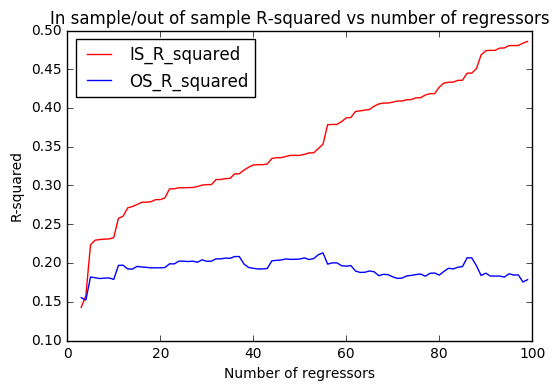

In [40]:
#In the sample test
OLS_R_2_IS=[] # make a list to store our in the sample R_squared
OLS_R_2_OS=[] #make a list to store our out the sample R_squared
var_list=base_columns+list_311

# A loop to run OLS while adding 311 regressors one by one
nvariables=range(3,100)#len(var_list)+1)
for j in nvariables: 
    model=sm.OLS(REsample1.sale_price,sm.add_constant(REsample1[var_list[:j]]),missing="drop").fit()
    OLS_R_2_IS.append(model.rsquared)
    #Out of the sample test
    Ypred2=model.predict(sm.add_constant(REsample2[var_list[:j]]))
    R_OS=1-((np.asarray(Ypred2)-REsample2.sale_price)**2).sum()/((REsample2.sale_price-np.mean(REsample2.sale_price))**2).sum()
    if R_OS<0: #cut negative values
        R_OS=0
    OLS_R_2_OS.append(R_OS)
    
#visualize 
plt.title('In sample/out of sample R-squared vs number of regressors')
plt.plot(nvariables,OLS_R_2_IS,'r',label='IS_R_squared')
plt.plot(nvariables,OLS_R_2_OS,'b',label='OS_R_squared')
plt.legend(loc='upper left')
plt.xlabel('Number of regressors')
plt.ylabel('R-squared')
plt.draw()

## Regularization

When fitting a linear regression with multiple features $x=(x^1,x^2,...,x^n)$ 
$$
y\sim w^T x
$$
the model might become complex and susceptible to overfitting. Complexity often comes with coefficients $w$ growing large in absolute values.

One way to reduce complexity is to penalize regression for the magnitude of the coefficients $w=(w^1,w^2,...,w^n)$, which can be measured by
$$
||w||_1=\sum\limits_j |w^j|
$$
or by 
$$
||w||_2^2=\sum\limits_j (w^j)^2
$$
So instead of simply minimizing 
$$
RSS(w)=\sum\limits_j (y_j-w^T x_j)^2
$$
where $x_j, y_j$ are observations for regressors and output variable, we minimize
$$
RSS(w)+\lambda ||w||_2^2=RSS(w)+\lambda \sum\limits_j (w^j)^2\to\min\hspace{10ex}(Ridge)
$$
or
$$
RSS(w)+\lambda ||w||_1=RSS(w)+\lambda \sum\limits_j \left|w^j\right|\to\min\hspace{10ex}(Lasso)
$$

The first model is known as Ridge, the second - as Lasso (least absolute shrinkage and selection operator) regularized regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized or constrained forms of the optimization problem are equally applicable.

Optimization problems (Ridge) and (Lasso) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

** NOTICE ** As the order of magnitude of $w^j$ is directly related to the scale of the regressors, it is practical to rescale them (e.g. by standardizing) to make sure the $w^j$ are comparable in scale. Otherwise penalization terms directly mixing components $w^j$ of different, sometimes incomparable, scale do not make too much sense.

From Bayesian standpoint (for those familiar with Bayesian inference) Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex}(Ridge\ solution)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (Ridge solution) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being often able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

In [41]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1) #try Ridge with an arbitrary regularization parameter alpha=1

Ridge.fit(REsample1[var_list],REsample1.sale_price)
# In the sample:
Ypred1=Ridge.predict(REsample1[var_list])
R_IS=1-((np.asarray(Ypred1)-REsample1.sale_price)**2).sum()/((REsample1.sale_price-np.mean(REsample1.sale_price))**2).sum()
print("The In-sample R-squared for Ridge is: {0}".format(R_IS))

Ridge_coef=Ridge.coef_

#Out of sample (use REsample2 as a validation sample first as we'll be tuning alpha)
YPred2=Ridge.predict(REsample2[var_list])
R_OS=1-((np.asarray(YPred2)-REsample2.sale_price)**2).sum()/((REsample2.sale_price-np.mean(REsample2.sale_price))**2).sum()
print("The Out-of-sample R-squared for Ridge: {0}".format(R_OS))

The In-sample R-squared for Ridge is: 0.527387608464
The Out-of-sample R-squared for Ridge: 0.147256947068


In [42]:
Ridge_coef[0:12]

array([  1.06709232e+02,   1.45196922e+01,   8.34696870e+02,
         2.51390137e+05,   1.89205800e+05,   3.03358647e+05,
        -2.28586367e+05,   5.50610039e+05,  -2.52722969e+05,
        -3.64301149e+05,  -1.73890442e+05,   2.69166940e+05])

In [43]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=1) #try Lasso with an arbitrary regularization parameter alpha=1

Lasso.fit(REsample1[var_list],REsample1.sale_price)
# In the sample:
YPred1=Lasso.predict(REsample1[var_list])
R_IS=1-((np.asarray(Ypred1)-REsample1.sale_price)**2).sum()/((REsample1.sale_price-np.mean(REsample1.sale_price))**2).sum()
print("The In-sample R-squared for Lasso is: {0}".format(R_IS))

Lasso_coef=Lasso.coef_

#Out of sample (use REsample2 as a validation sample first as we'll be tuning alpha)
YPred2=Lasso.predict(REsample2[var_list])
R_OS=1-((np.asarray(YPred2)-REsample2.sale_price)**2).sum()/((REsample2.sale_price-np.mean(REsample2.sale_price))**2).sum()
print("The Out-of-sample R-squared for Lasso: {0}".format(R_OS))

The In-sample R-squared for Lasso is: 0.527387608464
The Out-of-sample R-squared for Lasso: 0.12599431024


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [44]:
Lasso_coef[0:12]

array([  1.04347806e+02,   1.47639393e+01,   8.54261819e+02,
         2.48073468e+05,   1.59884271e+05,   4.37079158e+05,
        -1.47819651e+05,   2.61752538e+05,  -1.44143660e+05,
        -4.13954134e+04,  -2.26714337e+05,   9.93441722e+04])

In [45]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #lambdas: a list of lambda values to try
    #p: ratio of the validation sample size / total training size
    #Graph: plot the graph of R^2 values for different lambda

    R_2_OS=[]
    
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    
    for i in alphas:
        lm = RM(i)
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        err_OS=y_predict-y_valid
        R_2_OS_=1-np.var(err_OS)/np.var(y_valid)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_alpha = i
    
    if Graph==True:
        plt.title('OS-R-squared for different Alpha')
        if logl:
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return (best_alpha, best_R2)

In [57]:
var_list_=var_list[:100]

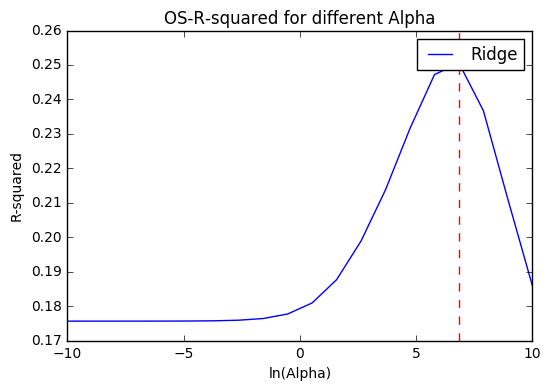

Optimal alpha for Ridge=936.45855262, R2=0.250543946352


In [58]:
alphas = np.exp(np.linspace(-10,10,20))
alpha_r_optimal,best_R2=Regularization_fit_alpha(1,REsample1[var_list_],REsample1.sale_price,REsample2[var_list_],REsample2.sale_price,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, R2={1}'.format(alpha_r_optimal,best_R2))

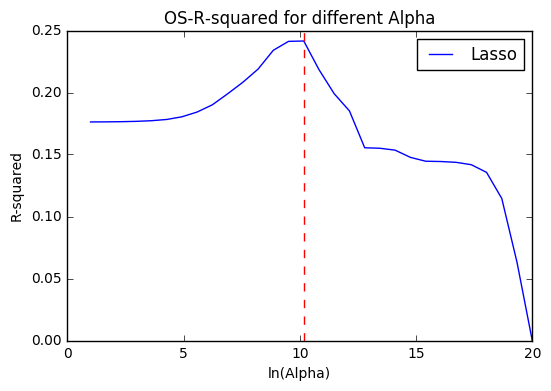

Optimal alpha for Lasso=26171.1723789, R2=0.241539266265


In [59]:
alphas = np.exp(np.linspace(1,20,30))
alpha_l_optimal,best_R2=Regularization_fit_alpha(2,REsample1[var_list_],REsample1.sale_price,REsample2[var_list_],REsample2.sale_price,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, R2={1}'.format(alpha_l_optimal,best_R2))

So while Lasso and Ridge can help reduce overfitting 

In [60]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_l_optimal) #try Lasso with an arbitrary regularization parameter alpha=1

Lasso.fit(REsample1[var_list_],REsample1.sale_price)
# In the sample:
YPred1=Lasso.predict(REsample1[var_list_])
R_IS=1-((np.asarray(Ypred1)-REsample1.sale_price)**2).sum()/((REsample1.sale_price-np.mean(REsample1.sale_price))**2).sum()
print("The In-sample R-squared for Lasso is: {0}".format(R_IS))

Lasso_coef=Lasso.coef_

#Out of sample (use REsample2 as a validation sample first as we'll be tuning alpha)
YPred2=Lasso.predict(REsample2[var_list_])
R_OS=1-((np.asarray(YPred2)-REsample2.sale_price)**2).sum()/((REsample2.sale_price-np.mean(REsample2.sale_price))**2).sum()
print("The Out-of-sample R-squared for Lasso: {0}".format(R_OS))

The In-sample R-squared for Lasso is: 0.527387608464
The Out-of-sample R-squared for Lasso: 0.241471202297


In [61]:
Lasso_coef

array([  2.18576138e+02,  -2.82035894e+00,  -6.31526615e+02,
         2.25664204e+05,   1.65604867e+05,   0.00000000e+00,
         0.00000000e+00,   7.90942479e+04,   0.00000000e+00,
         0.00000000e+00,  -1.32716625e+05,   0.00000000e+00,
        -0.00000000e+00,   3.56480988e+04,  -1.15019163e+05,
         0.00000000e+00,   1.37486254e+04,   0.00000000e+00,
         9.48724027e+03,  -2.44739647e+04,  -1.49614994e+04,
         9.96686409e+04,  -0.00000000e+00,   1.79205848e+04,
         3.10032389e+04,  -5.62803779e+03,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   5.54630884e+04,  -3.44551401e+03,
         3.95990810e+04,   0.00000000e+00,   5.64817845e+04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -5.38635462e+04,  -0.00000000e+00,
         4.54725677e+03,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,